In [40]:
import pdfplumber
import pandas as pd
import re
import os

In [41]:
column_names = ["club",	"last_name", "first_name", "position", "base_salary", "guaranteed_compensation"]

positions = ["F", "M", "D", "F", "G"]

clubs = ['Atlanta United', 'Austin FC', 'Charlotte FC', 'Chicago Fire', 'Chivas USA',
         'Colorado Rapids', 'Columbus Crew', 'DC United', 'FC Cincinnati',
         'FC Dallas', 'Houston Dynamo', 'Inter Miami', 'LA Galaxy', 'Los Angeles FC',
         'Major League Soccer', 'Minnesota United', 'Montreal Impact',
         'Nashville SC', 'New England Revolution', 'New York City FC',
         'New York Red Bulls', 'Orlando City SC', 'Philadelphia Union',
         'Portland Timbers', 'Real Salt Lake', 'San Jose Earthquakes',
         'Seattle Sounders FC', 'Sporting Kansas City', 'St. Louis City SC',
         'Toronto FC', 'Vancouver Whitecaps', 'Pool']

club_abr = {
    'ATL': 'Atlanta United',
    'AUS': 'Austin FC',
    'CLT': 'Charlotte FC',
    'CHI': 'Chicago Fire',
    'CHV': 'Chivas USA',
    'COL': 'Colorado Rapids',
    'CLB': 'Columbus Crew',
    'DC': 'DC United',
    'CIN': 'FC Cincinnati',
    'DAL': 'FC Dallas',
    'HOU': 'Houston Dynamo',
    'MIA': 'Inter Miami',
    'LA': 'LA Galaxy',
    'LAFC': 'Los Angeles FC',
    'MLS': 'Major League Soccer',
    'MIN': 'Minnesota United',
    'MTL': 'Montreal Impact',
    'NSH': 'Nashville SC',
    'NE': 'New England Revolution',
    'NYCFC': 'New York City FC',
    'NYRB': 'New York Red Bulls',
    'ORL': 'Orlando City SC',
    'PHI': 'Philadelphia Union',
    'POR': 'Portland Timbers',
    'RSL': 'Real Salt Lake',
    'SJ': 'San Jose Earthquakes',
    'SEA': 'Seattle Sounders FC',
    'SKC': 'Sporting Kansas City',
    'STL': 'St. Louis City SC',
    'TOR': 'Toronto FC',
    'VAN': 'Vancouver Whitecaps',
    'Pool': 'Pool'
}

team_region_mapping = {
    'Atlanta United': 'Eastern',
    'Austin FC': 'Western',
    'Charlotte FC': 'Eastern',
    'Chicago Fire': 'Eastern',
    'Chivas USA': 'Western',
    'Colorado Rapids': 'Western',
    'Columbus Crew': 'Eastern',
    'DC United': 'Eastern',
    'FC Cincinnati': 'Eastern',
    'FC Dallas': 'Western',
    'Houston Dynamo': 'Western',
    'Inter Miami': 'Eastern',
    'LA Galaxy': 'Western',
    'Los Angeles FC': 'Western',
    'Major League Soccer': 'N/A',
    'Minnesota United': 'Western',
    'Montreal Impact': 'Eastern',
    'Nashville SC': 'Western',
    'New England Revolution': 'Eastern',
    'New York City FC': 'Eastern',
    'New York Red Bulls': 'Eastern',
    'Orlando City SC': 'Eastern',
    'Philadelphia Union': 'Eastern',
    'Portland Timbers': 'Western',
    'Real Salt Lake': 'Western',
    'San Jose Earthquakes': 'Western',
    'Seattle Sounders FC': 'Western',
    'Sporting Kansas City': 'Western',
    'St. Louis City SC': 'Western',
    'Toronto FC': 'Eastern',
    'Vancouver Whitecaps': 'Western',
    'Pool': 'N/A'
}

def combine_elements(source_list, index1, index2):
    out_str = source_list[index1] + source_list[index2]
    del source_list[index2]
    source_list[index1] = out_str
    return source_list
    

def get_best_match(entry, option_list=clubs):

    if entry is None:
        return None
    best_match = None
    match_distance = float('inf')

    for option in option_list:
        distance = calc_lev_distance(entry, option)
        

        if distance < match_distance:
            best_match = option
            match_distance = distance


    return best_match

def calc_lev_distance(string1, string2):
    try:
        m = len(string1)
        n = len(string2)
    except TypeError:
        return(string1)

    # Create a matrix of size (m+1)x(n+1) to store the distances
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Initialize the first row and column of the matrix
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    # Calculate the distances using dynamic programming
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if string1[i - 1] == string2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])

    # Return the Levenshtein distance between the two strings
    return dp[m][n]

In [42]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2018.pdf')
pages = pdf.pages
mls_salaries_2018_df = pd.DataFrame(columns=column_names)
for page in pdf.pages:
        table = page.extract_table(table_settings={"vertical_strategy": "text", 
                                               "horizontal_strategy": "text", 
                                               "snap_tolerance": 9})
        del table[:4]
        for line in table:
            # combines spaces that have been incorrectly split using PDFPlumber
            line = combine_elements(line, 0, 1)
            line = combine_elements(line, 4, 5)
            line = combine_elements(line, 5, 6)
            if len(line) != 6:
                line = combine_elements(line, 0, 1)
            # combines last 3 spaces to then split with $
            line = combine_elements(line, 3, 4)
            line = combine_elements(line, 3, 4)
            # removes punctuations and spaces in the last 3 lines
            pattern = r"[^\w$]"
            line[-1] = cleaned_string = re.sub(pattern, '', line[-1])
            split_elements = line[-1].split('$')
            del line[-1]
            line.extend(split_elements)
            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2018_df = pd.concat([mls_salaries_2018_df, new_line_df], ignore_index=True)
pdf.close()
# mls_salaries_2018_df["position"] = mls_salaries_2018_df["position"].str.extract(r'([A-Z])')
mls_salaries_2018_df.position = mls_salaries_2018_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2018_df["base_salary"] = pd.to_numeric(mls_salaries_2018_df["base_salary"])
mls_salaries_2018_df["guaranteed_compensation"] = pd.to_numeric(mls_salaries_2018_df["guaranteed_compensation"])
mls_salaries_2018_df["base_salary"] = mls_salaries_2018_df["base_salary"] / 100
mls_salaries_2018_df["guaranteed_compensation"] = mls_salaries_2018_df["guaranteed_compensation"] / 100
mls_salaries_2018_df

,club,last_name,first_name,position,base_salary,guaranteed_compensation
0,New York Red Bulls,Abang,Anatole,F,68927.00,68927.00
1,New York City FC,Abdul-Salaam,Saad,D,106480.00,120230.00
2,Columbus Crew,Abu,Mohammed,M,175008.00,181258.00
3,Columbus Crew,Abubakar,Lalas,D,68250.04,75750.04
4,PhiladelphiaUnion,Accam,David,F,1250000.04,1250000.04
...,...,...,...,...,...,...
689,FC Dallas,Ziegler,Reto,D,750000.00,800000.00
690,LAFC,Zimmerman,Walker,D,235000.00,235000.00
691,Atlanta United,Zizzo,Sal,D,129999.96,129999.96
692,FC Dallas,Zobeck,Kyle,G,67500.00,67500.00


In [43]:
mls_salaries_2018_df.to_csv('data/mls_salaries/mls-salaries-2018.csv', index=False)

In [44]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2019.pdf')
pages = pdf.pages
mls_salaries_2019_df = pd.DataFrame(columns=column_names)
for i, page in enumerate(pdf.pages):
        table = page.extract_table(table_settings={"vertical_strategy": "text", 
                                               "horizontal_strategy": "text", 
                                               "snap_tolerance": 5})
        if i == 0:
            del table[:1]
        for line in table:
            # combines spaces that have been incorrectly split using PDFPlumber
            line = combine_elements(line, 0, 1)

            # combines last 3 spaces to then split with $
            line = combine_elements(line, 3, 4)
            line = combine_elements(line, 3, 4)
            # removes punctuations and spaces in the last 3 lines
            pattern = r"[^\w$]"
            line[-1] = cleaned_string = re.sub(pattern, '', line[-1])
            split_elements = line[-1].split('$')
            del line[-1]
            line.extend(split_elements)
            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2019_df = pd.concat([mls_salaries_2019_df, new_line_df], ignore_index=True)
pdf.close()
# mls_salaries_2019_df["position"] = mls_salaries_2019_df["position"].str.extract(r'([A-Z])')
mls_salaries_2019_df.position = mls_salaries_2019_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2019_df["base_salary"] = pd.to_numeric(mls_salaries_2019_df["base_salary"])
mls_salaries_2019_df["guaranteed_compensation"] = pd.to_numeric(mls_salaries_2019_df["guaranteed_compensation"])
mls_salaries_2019_df["base_salary"] = mls_salaries_2019_df["base_salary"] / 100
mls_salaries_2019_df["guaranteed_compensation"] = mls_salaries_2019_df["guaranteed_compensation"] / 100
mls_salaries_2019_df

,club,last_name,first_name,position,base_salary,guaranteed_compensation
0,PhiladelphiaUnion,Aaronson,Brenden,F,70000.08,98309.48
1,Seattle Sounders FC,Abdul-Salaam,Saad,D,70250.04,70250.04
2,Colorado Rapids,Abubakar,Lalas,D,135000.00,144937.50
3,Columbus Crew,Accam,David,F,1010004.00,1137920.00
4,Colorado Rapids,Acosta,Kellyn,M,549999.96,664999.96
...,...,...,...,...,...,...
709,FC Dallas,Ziegler,Reto,D,820000.08,870000.08
710,LAFC,Zimmerman,Walker,D,600000.00,600000.00
711,FC Dallas,Zobeck,Kyle,G,70875.00,70875.00
712,LA Galaxy,Zubak,Ethan,F,75000.00,78125.00


In [45]:
mls_salaries_2019_df.to_csv('data/mls_salaries/mls-salaries-2019.csv', index=False)

In [46]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2020.pdf')
pages = pdf.pages
mls_salaries_2020_df = pd.DataFrame(columns=column_names)
for i, page in enumerate(pdf.pages):
      table = page.extract_table(table_settings={"vertical_strategy": "text", 
                                               "horizontal_strategy": "text", 
                                               "snap_tolerance": 8})
        
      del table[:2]
      for line in table:
            # combines spaces that have been incorrectly split using PDFPlumber
            line = combine_elements(line, 2, 3)

            if len(line) == 7:
                  line = combine_elements(line, 2, 3)
            if len(line) == 5:
                  for pos in positions:
                        if line[2].endswith(pos):
                              line[2] = line[2][:-len(pos)]
                              line.insert(3, pos)
                              break

            # places player name in correct position
            player_name = line[:2]
            del line[:2]
            line.insert(1, player_name[0])
            line.insert(2, player_name[1])

            # combines last 3 spaces to then split with $
            if len(line) != 6:
                   line.insert(3, 'G')
            line = combine_elements(line, 3, 4)
            line = combine_elements(line, 3, 4)
            # # removes punctuations and spaces in the last 3 lines
            pattern = r"[^\w$]"
            line[-1] = cleaned_string = re.sub(pattern, '', line[-1])
            split_elements = line[-1].split('$')
            del line[-1]
            line.extend(split_elements)
            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2020_df = pd.concat([mls_salaries_2020_df, new_line_df], ignore_index=True)
            
pdf.close()
mls_salaries_2020_df.position = mls_salaries_2020_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2020_df["position"] = mls_salaries_2020_df["position"].str.extract(r'([A-Z])')
mls_salaries_2020_df

,club,last_name,first_name,position,base_salary,guaranteed_compensation
0,PhiladelphiaUnion,Aaronson,Brenden,M,85000,103309
1,FC Cincinnati,Abdul-Salaam,Saad,D,81375,90042
2,DC United,Abu,Mohammed,M,81375,81375
3,Colorado Rapids,Abubakar,Lalas,D,145000,154937
4,Nashville SC,Accam,David,F,875000,1002916
...,...,...,...,...,...,...
773,New York RedBulls,,Kaku,M,850000,850000
774,Orlando City SC,,Robinho,M,198000,205500
775,Philadelphia Union,,Ilsinho,M,425000,476250
776,San Jose Earthquakes,,Judson,M,320000,325000


In [47]:
mls_salaries_2020_df.to_csv('data/mls_salaries/mls-salaries-2020.csv', index=False)

In [48]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2021.pdf')
pages = pdf.pages
mls_salaries_2021_df = pd.DataFrame(columns=column_names)
for i, page in enumerate(pdf.pages):
        table = page.extract_table(table_settings={"vertical_strategy": "lines", 
                                               "horizontal_strategy": "lines", 
                                               "snap_tolerance": 8})
        if i == 0:
            del table[:2]
        for line in table:

            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2021_df = pd.concat([mls_salaries_2021_df, new_line_df], ignore_index=True)
            
pdf.close()
# mls_salaries_2021_df["position"] = mls_salaries_2021_df["position"].str.extract(r'([A-Z])')
mls_salaries_2021_df.position = mls_salaries_2021_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2021_df["base_salary"] = mls_salaries_2021_df["base_salary"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2021_df["guaranteed_compensation"] = mls_salaries_2021_df["guaranteed_compensation"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2021_df

,club,last_name,first_name,position,base_salary,guaranteed_compensation
0,Atlanta United,Adams,"Mohammed ""Mo""",M,121000.0,141000.0
1,Atlanta United,Ambrose,Mikey,D,81375.0,81375.0
2,Atlanta United,Araujo,Luiz,F,3600000.0,3941667.0
3,Atlanta United,Barco,Ezequiel,M,1875000.0,2358333.0
4,Atlanta United,Bauer,Josh,D,63547.0,63547.0
...,...,...,...,...,...,...
866,Vancouver Whitecaps,Sousa e Silva,Caio Alexandre,M,500000.0,539583.0
867,Vancouver Whitecaps,Teibert,Russell,M,350000.0,387500.0
868,Vancouver Whitecaps,Veselinovic,Ranko,D,360000.0,445500.0
869,Vancouver Whitecaps,Vite,Pedro,M,556000.0,609997.0


In [49]:
mls_salaries_2021_df.to_csv('data/mls_salaries/mls-salaries-2021.csv', index=False)

In [50]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2022.pdf')
pages = pdf.pages
mls_salaries_2022_df = pd.DataFrame(columns=column_names)
for i, page in enumerate(pdf.pages):
        table = page.extract_table(table_settings={"vertical_strategy": "lines", 
                                               "horizontal_strategy": "lines", 
                                               "snap_tolerance": 9})
        if i == 0:
            del table[:1]
        for line in table:

            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2022_df = pd.concat([mls_salaries_2022_df, new_line_df], ignore_index=True)
            
pdf.close()
# mls_salaries_2022_df["position"] = mls_salaries_2022_df["position"].str.extract(r'([A-Z])')
mls_salaries_2022_df.position = mls_salaries_2022_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2022_df["last_name"] = mls_salaries_2022_df["last_name"].str.replace(r'^[a-z]+', '', regex=True)
mls_salaries_2022_df["base_salary"] = mls_salaries_2022_df["base_salary"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2022_df["guaranteed_compensation"] = mls_salaries_2022_df["guaranteed_compensation"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2022_df

,club,last_name,first_name,position,base_salary,guaranteed_compensation
0,Atlanta United,Almada,Thiago,F,1650000.0,2332000.0
1,Atlanta United,Alonso,Osvaldo,M,84000.0,84000.0
2,Atlanta United,Ambrose,Mikey,D,85444.0,85444.0
3,Atlanta United,Araujo,Luiz,F,3600000.0,4480333.0
4,Atlanta United,Barco,Ezequiel,M,2200000.0,2200000.0
...,...,...,...,...,...,...
889,Vancouver Whit,Scoaupssa e Silva,Caio Alexand,M,500000.0,562500.0
890,Vancouver Whit,Tceaibpesrt,Russell,M,400000.0,449375.0
891,Vancouver Whit,Vceaspeslinovic,Ranko,D,405000.0,490500.0
892,Vancouver Whit,Vcitaeps,Pedro,M,556000.0,609997.0


In [51]:
mls_salaries_2022_df.to_csv('data/mls_salaries/mls-salaries-2022.csv', index=False)

In [52]:
pdf = pdfplumber.open('data/mls_salaries/PDF/mls_salaries_2023.pdf')
pages = pdf.pages
mls_salaries_2023_df = pd.DataFrame(columns=column_names)
for i, page in enumerate(pdf.pages):
        table = page.extract_table(table_settings={"vertical_strategy": "lines", 
                                               "horizontal_strategy": "lines", 
                                               "snap_tolerance": 8})
        
        del table[:1]
        for line in table:

            new_line_df = pd.DataFrame([line], columns=column_names)
            mls_salaries_2023_df = pd.concat([mls_salaries_2023_df, new_line_df], ignore_index=True)
            
pdf.close()
mls_salaries_2023_df.position = mls_salaries_2023_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_2023_df["position"] = mls_salaries_2023_df["position"].str.extract(r'([A-Z])')
mls_salaries_2023_df["base_salary"] = mls_salaries_2023_df["base_salary"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2023_df["guaranteed_compensation"] = mls_salaries_2023_df["guaranteed_compensation"].str.replace('$', '',  regex=False).str.replace(',', '',  regex=False).astype(float)
mls_salaries_2023_df

,club,last_name,first_name,position,base_salary,guaranteed_compensation
0,Atlanta United,McFadden,Aiden,D,85444.0,85444.0
1,Atlanta United,Fortune,Ajani,M,67360.0,67360.0
2,Atlanta United,Sejdic,Amar,D,85444.0,92111.0
3,Atlanta United,Gutman,Andrew,D,350000.0,381250.0
4,Atlanta United,Guzan,Brad,G,600000.0,612500.0
...,...,...,...,...,...,...
864,Vancouver Whitecaps,Córdova,Sergio,F,981818.0,1050568.0
865,Vancouver Whitecaps,Becher,Simon,F,67360.0,70485.0
866,Vancouver Whitecaps,Hasal,Thomas,G,203000.0,222412.0
867,Vancouver Whitecaps,Blackmon,Tristan,D,400000.0,451208.0


In [53]:
mls_salaries_2023_df.to_csv('data/mls_salaries/mls-salaries-2023.csv', index=False)

In [54]:
directory = "data/mls_salaries/"
mls_salaries_df = pd.DataFrame()
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        year = filename[-8:-4]  # Extract the year from the filename
        
        # Read the CSV file into a temporary DataFrame
        temp_df = pd.read_csv(filepath)
        
        # Add a 'Year' column with the extracted year value
        temp_df['year'] = year
        
        # Append the temporary DataFrame to the combined DataFrame
        mls_salaries_df = pd.concat([mls_salaries_df, temp_df], ignore_index=True)
mls_salaries_df

,club,last_name,first_name,position,base_salary,guaranteed_compensation,year
0,VAN,Abdallah,Aminu,M,46500.0,46500.00,2013
1,DAL,Acosta,Kellyn,M,46500.0,70500.00,2013
2,VAN,Adekugbe,Samuel,D,46500.0,51500.00,2013
3,TOR,Agbossoumonde,Gale,D,46500.0,53166.67,2013
4,NE,Agudelo,Juan,F,145000.0,175000.00,2013
...,...,...,...,...,...,...,...
10368,Vancouver Whit,Scoaupssa e Silva,Caio Alexand,M,500000.0,562500.00,2022
10369,Vancouver Whit,Tceaibpesrt,Russell,M,400000.0,449375.00,2022
10370,Vancouver Whit,Vceaspeslinovic,Ranko,D,405000.0,490500.00,2022
10371,Vancouver Whit,Vcitaeps,Pedro,M,556000.0,609997.00,2022


In [55]:
mls_salaries_df['club'] = mls_salaries_df['club'].replace(club_abr)
mls_salaries_df.position = mls_salaries_df.position.apply(lambda x: get_best_match(x, positions))
mls_salaries_df.club = mls_salaries_df.club.apply(lambda x: get_best_match(x, clubs))
mls_salaries_df['conference'] = mls_salaries_df['club'].map(team_region_mapping)

In [56]:
mls_salaries_df.to_csv('data/mls_salaries_masterlist.csv', index=False)

In [57]:
mls_salaries_df = pd.read_csv("data/mls_salaries_masterlist.csv")
mls_salaries_df.sample(20)

,club,last_name,first_name,position,base_salary,guaranteed_compensation,year,conference
10077,New York Red Bulls,"BuMllasrcucci, Jr.",Anthony,G,66724.00,66724.00,2022,Eastern
1849,San Jose Earthquakes,Sealy,Scott,F,138000.00,145000.00,2010,Western
9078,Nashville SC,Mukhtar,Hany,M,2900000.00,3188750.00,2023,Western
7768,Minnesota United,Raitala,Jukka,D,285000.00,306350.00,2021,Western
3650,Colorado Rapids,Jones,Jermaine,M,600000.00,650000.00,2016,Western
8426,Pool,Krupnik,Leonid,D,144000.00,144000.00,2009,NaN
2769,Pool,McLaws,Shawn,D,50000.00,50000.00,2015,NaN
4893,New York City FC,Chanot,Maxime,D,650000.04,650000.04,2019,Eastern
10335,Toronto FC,Singh,Luke,D,84000.00,91966.00,2022,Eastern
3439,DC United,Pontius,Chris,F,350000.00,381000.00,2014,Eastern


In [58]:
mlb_salaries_df = pd.read_csv("data/mlb_salaries.csv")
mlb_salaries_df.sample(20)

,playerid,player_name,weight,height,bats,throws,season,league,teamid,team,franchise,salary
28286,zuninmi01,Mike Zunino,220,74,R,R,2014,AL,SEA,Seattle Mariners,Seattle Mariners,504100
3360,buhneja01,Jay Buhner,220,75,R,R,1994,AL,SEA,Seattle Mariners,Seattle Mariners,4350000
25099,templga01,Garry Templeton,175,71,B,R,1988,NL,SDN,San Diego Padres,San Diego Padres,1143502
3486,burnese01,Sean Burnett,185,71,L,L,2010,NL,WAS,Washington Nationals,Washington Nationals,775000
11942,hughelu01,Luke Hughes,205,71,R,R,2012,AL,OAK,Oakland Athletics,Oakland Athletics,485000
6012,davisti01,Tim Davis,165,71,L,L,1996,AL,SEA,Seattle Mariners,Seattle Mariners,140000
3672,byrneer01,Eric Byrnes,200,74,R,R,2007,NL,ARI,Arizona Diamondbacks,Arizona Diamondbacks,4575000
4064,carmora01,Rafael Carmona,185,74,L,R,1996,AL,SEA,Seattle Mariners,Seattle Mariners,125000
24255,stantmi02,Mike Stanton,190,73,L,L,1991,NL,ATL,Atlanta Braves,Atlanta Braves,120000
13435,kershcl01,Clayton Kershaw,228,76,L,L,2014,NL,LAN,Los Angeles Dodgers,Los Angeles Dodgers,4000000


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

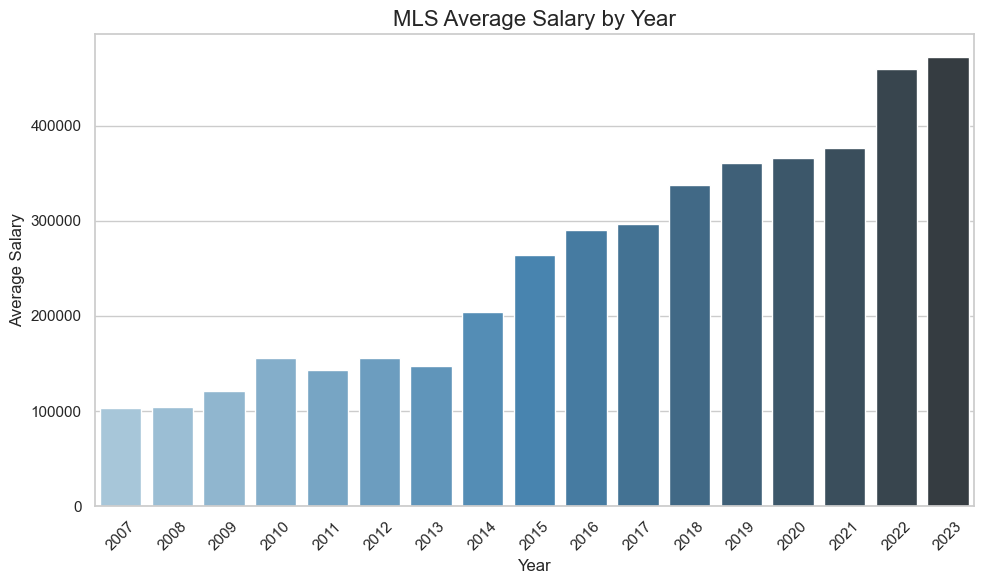

In [90]:
# Calculate the average salary for each year
average_salary_by_year = mls_salaries_df.groupby('year')['base_salary'].mean()


# Set the style using seaborn
sns.set(style="whitegrid")

# Create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=average_salary_by_year.index, y=average_salary_by_year.values, palette="Blues_d")
plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.title('MLS Average Salary by Year', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

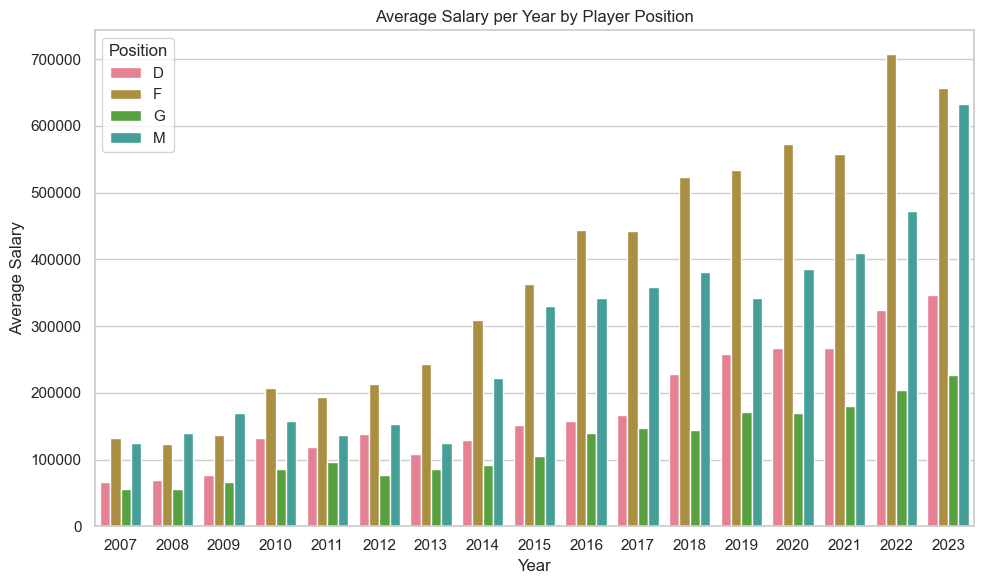

In [97]:
# Calculate average salary per year and position
average_salary = mls_salaries_df.groupby(['year', 'position'])['base_salary'].mean().reset_index()

# Pivot table to reshape the data
pivot_table = average_salary.pivot_table(index='year', columns='position', values='base_salary', fill_value=0)

# Reshape the data using melt
melted_data = average_salary.melt(id_vars=['year', 'position'], value_vars='base_salary', var_name='Metric', value_name='Average Salary')

# Stacked bar graph using seaborn
plt.figure(figsize=(10, 6))
sns.set_palette('husl')
sns.barplot(data=melted_data, x='year', y='Average Salary', hue='position')

plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.title('Average Salary per Year by Player Position')
plt.legend(title='Position')
plt.tight_layout()
plt.show()

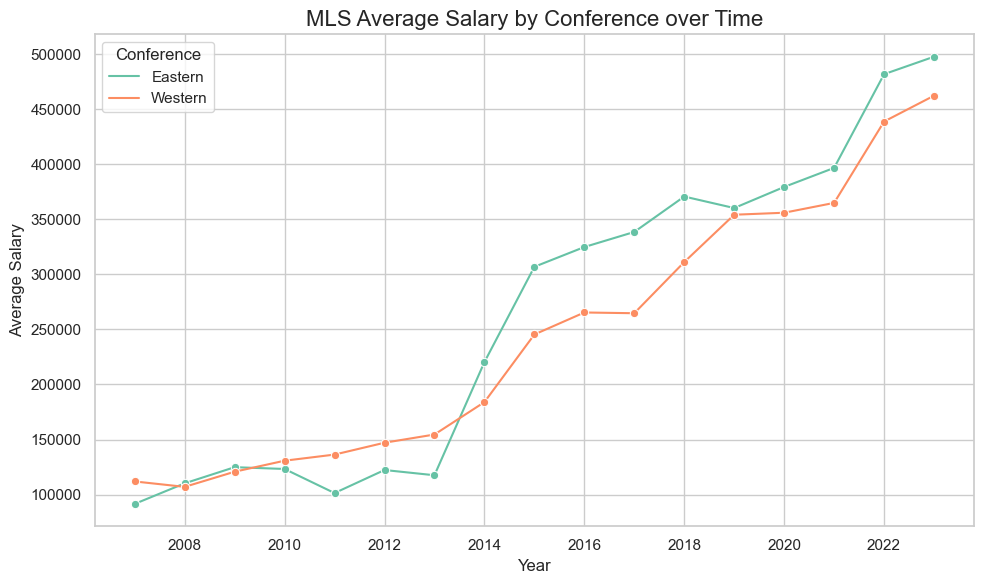

In [67]:
average_salary_by_region_year = mls_salaries_df.groupby(['conference', 'year'])['base_salary'].mean().reset_index()

# Set the style using seaborn
sns.set(style="whitegrid")

# Create the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_salary_by_region_year, x='year', y='base_salary', hue='conference', palette='Set2', marker='o')

plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.title('MLS Average Salary by Conference over Time', fontsize=16)
plt.legend(title='Conference')
plt.tight_layout()

plt.show()

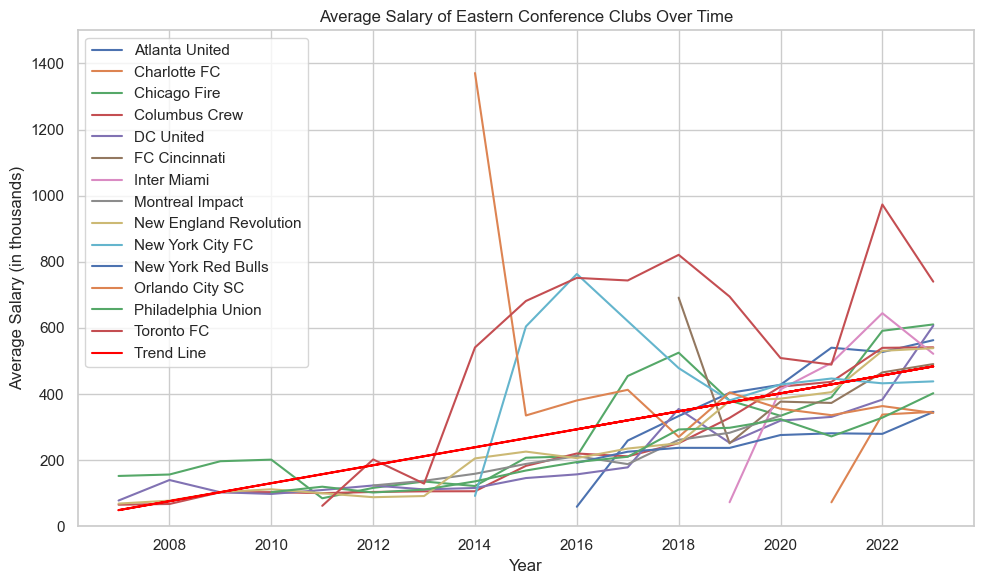

In [84]:

# Filter Eastern conference clubs
eastern_clubs = mls_salaries_df[mls_salaries_df['conference'] == 'Eastern']

# Calculate yearly average salary for each club
average_salary = eastern_clubs.groupby(['club', 'year'])['base_salary'].mean().reset_index()
average_salary['base_salary'] = average_salary['base_salary'] / 1000

# Line graph with trend line
plt.figure(figsize=(10, 6))
for club in average_salary['club'].unique():
    club_data = average_salary[average_salary['club'] == club]
    plt.plot(club_data['year'], club_data['base_salary'], label=club)

# Fit trend line
x = average_salary['year']
y = average_salary['base_salary']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), linestyle='-', color='red', label='Trend Line')

plt.xlabel('Year')
plt.ylabel('Average Salary (in thousands)')
plt.title('Average Salary of Eastern Conference Clubs Over Time')
plt.ylim(0, 1500)
plt.legend()
plt.tight_layout()
plt.show()

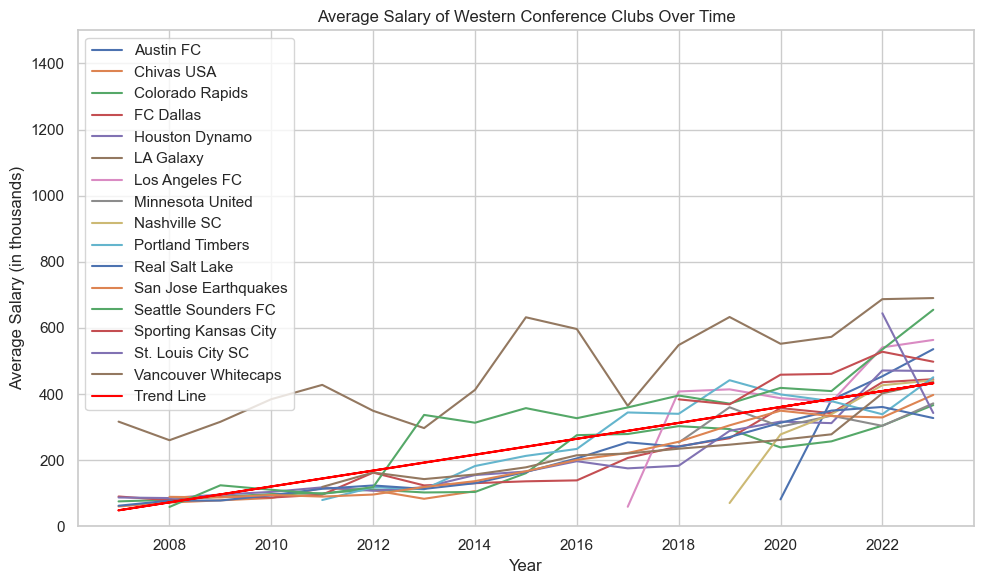

In [83]:
# Filter Eastern conference clubs
eastern_clubs = mls_salaries_df[mls_salaries_df['conference'] == 'Western']

# Calculate yearly average salary for each club
average_salary = eastern_clubs.groupby(['club', 'year'])['base_salary'].mean().reset_index()
average_salary['base_salary'] = average_salary['base_salary'] / 1000

# Line graph with trend line
plt.figure(figsize=(10, 6))
for club in average_salary['club'].unique():
    club_data = average_salary[average_salary['club'] == club]
    plt.plot(club_data['year'], club_data['base_salary'], label=club)

# Fit trend line
x = average_salary['year']
y = average_salary['base_salary']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), linestyle='-', color='red', label='Trend Line')

plt.xlabel('Year')
plt.ylabel('Average Salary (in thousands)')
plt.title('Average Salary of Western Conference Clubs Over Time')
plt.ylim(0, 1500)
plt.legend()
plt.tight_layout()
plt.show()